In [1]:
# import stuff
import os,sys
import glob
#import pandas
from osgeo import gdal
#import datetime 
import numpy as np
# from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
import h5py
import fsspec
import gc
from collections import namedtuple
import shapely.wkt as wkt
import rasterio
from rasterio.transform import from_origin
from rasterio import merge
from rasterio.crs import CRS
import rioxarray
%matplotlib  widget 

https://search.asf.alaska.edu/#/?
dataset=OPERA-S1
&zoom=9.267
&center=-116.062,32.118
&polygon=POLYGON((-115.8213%2032.498,-115.6928%2032.498,-115.6928%2032.5934,-115.8213%2032.5934,-115.8213%2032.498))
&start=2016-07-01T04:00:00Z
&end=2018-01-02T04:59:59Z
&resultsLoaded=true
&granule=OPERA_L2_CSLC-S1_T173-370325-IW2_20160702T134425Z_20240611T004736Z_S1A_VV_v1.1
&productTypes=CSLC
&flightDirs=Descending
&maxResults=250

In [27]:
# try making a list of files I want to use/download with an API string 

#track =  
date1 = '&start=2019-05-24'
date2 = '&end=2019-09-03'
polygon = '&intersectsWith=POLYGON((-115.8213 32.498,-115.6928 32.498,-115.6928 32.5934,-115.8213 32.5934,-115.8213 32.498))'
workdir = '/home/ocp4/data/LagunaSalada/Notebooks_github/21_stitch_CSLCs_together/'

# apistring='https://api.daac.asf.alaska.edu/services/search/param?platform=OPERA-S1&beamSwath=IW&processingLevel=SLC'+sC.track+sC.date1+sC.date2+sC.polygon
apistring='https://api.daac.asf.alaska.edu/services/search/param?dataset=OPERA-S1'+polygon+date1+date2


#apistring='https://api.daac.asf.alaska.edu/services/search/param?dataset=OPERA-S1&start=2016-07-01T04:00:00Z&end=2018-01-02T04:59:59Z+&flightDirs=Descending'+polygon


#os.system('wget \"'+apistring+'&output=csv\" -O '+workdir+'/list.csv -q')
# this gives api that can be searched as url for list of files using different output types
print(apistring+'&output=count')
# to search this api, copy the apistring and add "&output=count" for output as a count

https://api.daac.asf.alaska.edu/services/search/param?dataset=OPERA-S1&intersectsWith=POLYGON((-115.8213 32.498,-115.6928 32.498,-115.6928 32.5934,-115.8213 32.5934,-115.8213 32.498))&start=2019-05-24&end=2019-09-03&output=count


In [2]:
def read_cslc(h5file, version='calval'):
    # Load the CSLC and necessary metadata
    if version == 'gamma':
        DATA_ROOT = 'science/SENTINEL1'
        grid_path = f'{DATA_ROOT}/CSLC/grids'
        metadata_path = f'{DATA_ROOT}/CSLC/metadata'
        burstmetadata_path = f'{DATA_ROOT}/CSLC/metadata/processing_information/s1_burst_metadata'
        id_path = f'{DATA_ROOT}/identification'
    else:
        grid_path = f'data'
        metadata_path = f'metadata'
        burstmetadata_path = f'metadata/processing_information/input_burst_metadata'
        id_path = f'identification'

    if h5file[:2] == 's3':
        print(f'Streaming: {h5file}')  
        s3f = fsspec.open(h5file, mode='rb', anon=True, default_fill_cache=False)
        with h5py.File(s3f.open(),'r') as h5:
            cslc = h5[f'{grid_path}/VV'][:]
        del s3f
    else:
        with h5py.File(h5file,'r') as h5:
            print(f'Opening: {h5file}')  
            cslc = h5[f'{grid_path}/VV'][:]
    # Collect garbage
    del h5
    gc.collect()
    return cslc

def cslc_info(h5file, version='calval'):

    # Load the CSLC and necessary metadata
    if version == 'gamma':
        DATA_ROOT = 'science/SENTINEL1'
        grid_path = f'{DATA_ROOT}/CSLC/grids'
        metadata_path = f'{DATA_ROOT}/CSLC/metadata'
        burstmetadata_path = f'{DATA_ROOT}/CSLC/metadata/processing_information/s1_burst_metadata'
        id_path = f'{DATA_ROOT}/identification'  
    else:
        grid_path = f'data'
        metadata_path = f'metadata'
        burstmetadata_path = f'metadata/processing_information/input_burst_metadata'
        id_path = f'identification'

    if h5file[:2] == 's3':
        s3f = fsspec.open(h5file, mode='rb', anon=True, default_fill_cache=False)
        with h5py.File(s3f.open(),'r') as h5:
            xcoor = h5[f'{grid_path}/x_coordinates'][:]
            ycoor = h5[f'{grid_path}/y_coordinates'][:]
            dx = h5[f'{grid_path}/x_spacing'][()].astype(int)
            dy = h5[f'{grid_path}/y_spacing'][()].astype(int)
            epsg = h5[f'{grid_path}/projection'][()].astype(int)
            bounding_polygon =h5[f'{id_path}/bounding_polygon'][()].astype(str) 
            orbit_direction = h5[f'{id_path}/orbit_pass_direction'][()].astype(str)         
    else:
        with h5py.File(h5file,'r') as h5:
            xcoor = h5[f'{grid_path}/x_coordinates'][:]
            ycoor = h5[f'{grid_path}/y_coordinates'][:]
            dx = h5[f'{grid_path}/x_spacing'][()].astype(int)
            dy = h5[f'{grid_path}/y_spacing'][()].astype(int)
            epsg = h5[f'{grid_path}/projection'][()].astype(int)
            bounding_polygon =h5[f'{id_path}/bounding_polygon'][()].astype(str) 
            orbit_direction = h5[f'{id_path}/orbit_pass_direction'][()].astype(str)
    cslc = namedtuple('burst_info', ['x_coord', 'y_coord', 'dx', 'dy',
                                     'epsg', 'bbox', 'orbit_direction'])
    cslc_poly = wkt.loads(bounding_polygon)
    bbox = [cslc_poly.bounds[0], cslc_poly.bounds[2],
            cslc_poly.bounds[1], cslc_poly.bounds[3]]
    return cslc(xcoor, ycoor, dx, dy, epsg, bbox, orbit_direction)

def rasterWrite(outtif,arr,transform,epsg,dtype='float32'):
    #writing geotiff using rasterio
    
    new_dataset = rasterio.open(outtif, 'w', driver='GTiff',
                            height = arr.shape[0], width = arr.shape[1],
                            count=1, dtype=dtype,
                            crs=CRS.from_epsg(epsg),
                            transform=transform,nodata=np.nan)
    new_dataset.write(arr, 1)
    new_dataset.close() 

def custom_merge(old_data, new_data, old_nodata, new_nodata, **kwargs):    
    mask = np.logical_and(~old_nodata, ~new_nodata)
    old_data[mask] = new_data[mask]
    mask = np.logical_and(old_nodata, ~new_nodata)
    old_data[mask] = new_data[mask]

In [3]:
cslc_folder = '/home/ocp4/data/LagunaSalada/Data_and_Figs/21_CSLCs'
cslc_files = [os.path.basename(x) for x in glob.glob(cslc_folder+"/*.h5")]
for i in range(len(cslc_files)):
    print(cslc_files[i])

OPERA_L2_CSLC-S1_T173-370325-IW2_20160702T134425Z_20240611T004736Z_S1A_VV_v1.1.h5
OPERA_L2_CSLC-S1_T173-370326-IW2_20160702T134428Z_20240611T004736Z_S1A_VV_v1.1.h5


In [4]:
# These are in UTM 
slc_1 = read_cslc(cslc_folder+'/'+cslc_files[0])
print(np.shape(slc_1))
slc_2 = read_cslc(cslc_folder+'/'+cslc_files[1])
print(np.shape(slc_2))

Opening: /home/ocp4/data/LagunaSalada/Data_and_Figs/21_CSLCs/OPERA_L2_CSLC-S1_T173-370325-IW2_20160702T134425Z_20240611T004736Z_S1A_VV_v1.1.h5
(4608, 20616)
Opening: /home/ocp4/data/LagunaSalada/Data_and_Figs/21_CSLCs/OPERA_L2_CSLC-S1_T173-370326-IW2_20160702T134428Z_20240611T004736Z_S1A_VV_v1.1.h5
(4611, 20616)


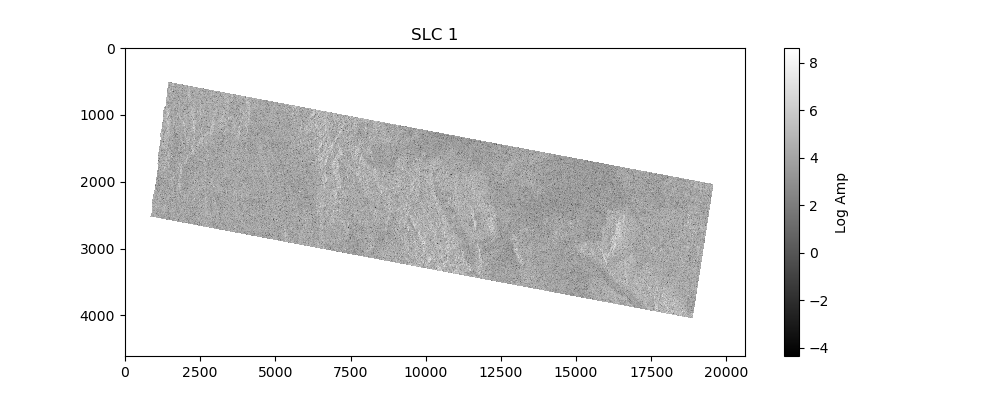

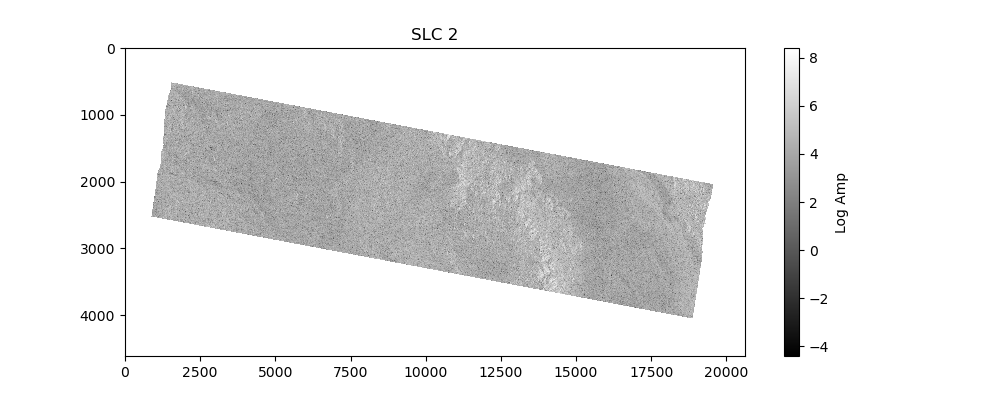

In [5]:
# plot them both, just amplitudes for now 
plt.figure(figsize=(10,4))
plt.imshow(np.log(np.abs(slc_1)),cmap='gray',aspect='auto',interpolation='nearest')
plt.colorbar(label='Log Amp')
plt.title('SLC 1')
plt.show()

plt.figure(figsize=(10,4))
plt.imshow(np.log(np.abs(slc_2)),cmap='gray',aspect='auto',interpolation='nearest')
plt.colorbar(label='Log Amp')
plt.title('SLC 2')
plt.show()

In [6]:
# want to stitch them together: other notebook does this once converted to geotiff, so try that.

for id in range(2):
    metadata = cslc_info(cslc_folder+'/'+cslc_files[id])

    transform = from_origin(metadata.x_coord[0],metadata.y_coord[0],
                            metadata.dx, np.abs(metadata.dy))
    if id==0:
        rasterWrite(f'slc_{id}.tif', np.abs(slc_1),
                    transform, metadata.epsg, dtype=rasterio.float32)
    elif id==1:
        rasterWrite(f'slc_{id}.tif', np.abs(slc_2),
                    transform, metadata.epsg, dtype=rasterio.float32)
    
# this successfully saved the geotiff for slc_0 and slc_1.tif 

In [7]:
# Merge GeoTiff files with rasterio
slc_geotiff_files = [(f'slc_{id}.tif') for id in range(2)]
files_to_mosaic = []
save_fn = f'stitched_SLC.tif'

for f in slc_geotiff_files:
    src = rasterio.open(f)
    files_to_mosaic.append(src)

# Write merged interferogram to GeoTiff
dest, output_transform=merge.merge(files_to_mosaic, method=custom_merge)
with rasterio.open(slc_geotiff_files[0]) as src:
        out_meta = src.meta.copy() 
out_meta.update({"driver": "GTiff",
                 "height": dest.shape[1],
                 "width": dest.shape[2],
                 "transform": output_transform})
with rasterio.open(save_fn, "w", **out_meta) as dest1:
        dest1.write(dest)
        dest1.close()

# looks like this worked: saved the merged slc as a geotiff. Check in next cell.

In [8]:
# Load in the stitched SLC and make sure it looks ok. 
# Read the merged raster file
src = rioxarray.open_rasterio(save_fn)
merged_slc = src.rio.reproject("EPSG:4326")[0]             # Folium maps are in EPSG:4326
minlon,minlat,maxlon,maxlat = merged_slc.rio.bounds()
del src

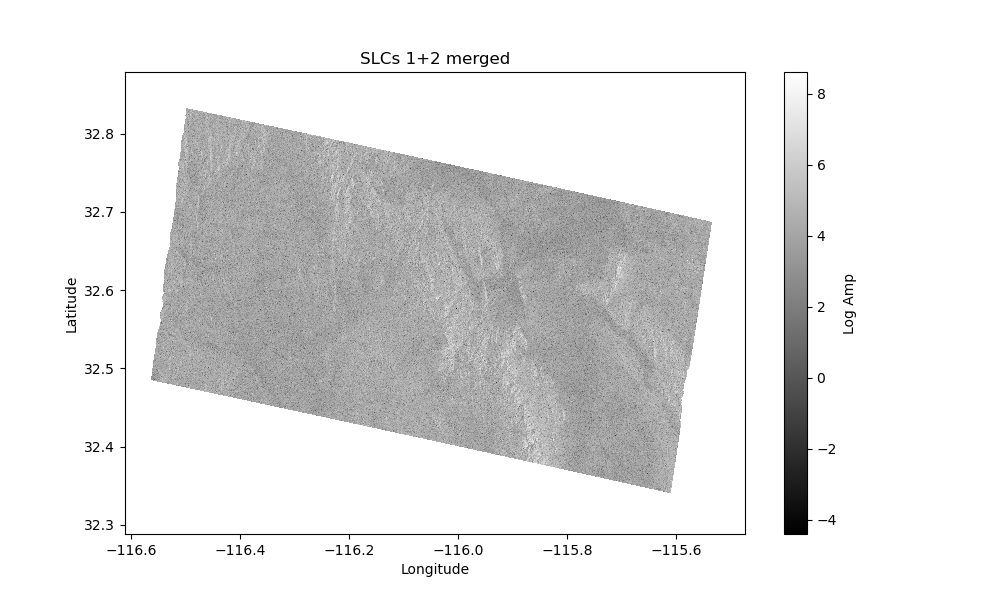

In [10]:
# Define new bounding box
new_bbox = [minlon,maxlon,minlat,maxlat]
plt.figure(figsize=(10,6))
plt.imshow(np.log(merged_slc),cmap='gray',aspect='auto',interpolation='nearest',\
           origin='upper', extent=new_bbox)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Log Amp')
plt.title('SLCs 1+2 merged')
plt.show()